# Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Define

In [ ]:
class VariableArray():
    def __init__(self, size):
        self.v = np.random.normal(0., 1., size) # array values
        self.td = np.zeros(self.v.size) # totally differentiation, used to descent
        self.work = np.ones(self.v.size) # working components, defult to be fully connected
    
    def assign_values(self, values):
        self.v = values
        self.td = np.zeros(self.v.size)
        self.work = np.ones(self.v.size) 
    
    def descent(self, step = 1.):
        self.v -= step * self.td * self.work
    
    def zerodiff(self):
        self.td *= 0.

class Identity():
    def trans(self, x):
        return x
    
    def diff(self, x):
        return np.ones(x.shape)
        
class Sigmoid():    
    def trans(self, x):
        return 1. / (1. + np.exp(-x))
    
    def diff(self, x): 
        return 1. / (np.exp(x) + np.exp(-x) + 2.)

class Hypertan():
    def trans(self, x):
        return np.tanh(x)
    
    def diff(self, x):
        return 1. / (np.cosh(x)**2)
    
class Relu():
    def trans(self, x):
        return x*(x>0)
    
    def diff(self, x):
        return (x>0)

class LeakyRelu():
    def __init__(self, alpha = 0.):
        self.alpha = alpha
    
    def trans(self, x):
        return x*(x>0) + self.alpha*x*(x<0)
    
    def diff(self, x):
        return (x>0) + self.alpha*(x<0)

class SoftPlus():
    def trans(self, x):
        return np.log(1. + np.exp(x))
    
    def diff(self, x):
        return 1. / (1. + np.exp(-x))

class Layer():
    def __init__(self, neuron_n, activation_function):
        self.nn = neuron_n
        self.af = activation_function
        self.w = VariableArray((0, neuron_n)) # linear weights working before active function
        self.b = VariableArray((neuron_n)) # bias working before active function
        self.x = np.zeros((0, neuron_n))
        self.y = np.zeros((0, neuron_n))
    
    def forward(self, _input):
        self.x = np.dot(self.w.v, _input)
        self.y = self.af.trans(self.x)
    
    def backward(self, _input):
        self.b.td = np.sum(self.af.diff(self.x)*_input, axis=1)

class DogikoLearn():
    def __init__(self, loss_function = "r2"):
        self.lf = loss_function # loss function type
        self.ly = [] # layers list
    
    def set_training_data(self, training_input, training_labels):
        self.tx = np.array(training_input) # training data input
        self.ty = np.array(training_labels) # training data lables(answers)
        if self.tx.size[0] != self.ty.size[0]:
            temp_min = min(self.tx.size[0], self.ty.size[0])
            self.tx = self.tx[:temp_min]
            self.ty = self.ty[:temp_min]
            print("training data #input != #output, took the minimun size automatically")
        
        self.xs = self.tx.size[1] # size of each datum input
        self.ys = self.ty.size[1] # size of each datum output
    
    def set_validating_data(self, validating_input, validating_labels):
        self.vx = np.array(validating_input) # validating data input
        self.vy = np.array(validating_labels) # validating data lables(answers)
        if self.vx.size[1] != self.xs:
            raise ValueError("validating data input size should be equal to training data")
        
        if self.vy.size[1] != self.ys:
            raise ValueError("validating data lables size should be equal to training data")
    
    def add_layer(self, layer):
        self.ly.append(layer)
    
    def build(self):
        self.ln = len(self.ly) # amount of layers
        self.ly[0].w = np.random.normal(0., 1., (self.xs, self.ly[0].nn))
        self.ly[0].b = np.random.normal(0., 1., (self.ly[0].nn))
        for l in range(1:self.ln):
            self.ly[l].w = np.random.normal(0., 1., (self.ly[l-1].nn, self.ly[l].nn))
            self.ly[l].b = np.random.normal(0., 1., (self.ly[l].nn))
        
        if self.ly[-1].nn != self.ys: # cheak output size
            raise ValueError("output layer must has the same size with datum lables(answer)")
    
    def prediction(self, data_input):
        self.px = np.array(data_input) # prediction data input of last time predic
        if self.px.size[1] != self.xs:
            raise ValueError("datum size error")
        
        self.ly[0].forward(self.px.T)
        for l in range(1:self.ln):
            self.ly[l].forward(self.ly[l-1].y)
        
        self.py = self.ly[l].y # prediction result of last time predict
    
    def batch_fit(self, batch_input, batch_labels):


In [2]:
def guess_square_error(input_answers, input_weights = None):
    answers = np.array(input_answers, dtype = "float64") # formate float64
    rowwise_mean = np.average(answers, axis = 0)
    answers -= rowwise_mean
    square_ans = answers * answers
    if input_weights != None:
        for w in range(len(input_weights)):
            square_ans[w] *= input_weights[w]
    
    return square_ans.sum()

class SingleEntryMatrix():
    def __init__(self, size):
        self.elements = np.zeros(size + size, dtype = bool)
        for i in range(size[0]):
            for j in range(size[1]):
                self.elements[i][j][i][j] = True

class VariableArray():
    def __init__(self, size, mean = 0., std = 1., work_components = 1., is_independent_learning = False):
        self.size = size
        self.values = np.random.normal(mean, std, size)
        self.diff = np.zeros(size)
        self.drop = np.ones(size, dtype = bool)
        if work_components == 1:
            self.work = np.ones(size, dtype = bool)
        else:
            self.work = (np.random.random(size) < work_components)
        
        self.values *= self.work
        
        if is_independent_learning:
            self.eta_m = np.zeros(size)
        else:
            self.eta_m = None
    
    def move(self, eta = None):
        if eta == None:
            self.values -= self.eta_m * self.diff * self.work
        else:
            self.values -= eta * self.diff * self.work
    
    def zerodiff(self):
        self.diff *= 0.
    
    def set_drop(self, rate):
        self.drop = (np.random.random(size) < rate)

class Sigmoid():
    def set_dim(self, domain_dim):
        self.dd = domain_dim # domain dimension
        self.cd = domain_dim # codomain dimension
    
    def trans(self, x):
        return 1. / (1. + np.exp(-x))
    
    def diff(self, x): 
        return np.diag(1. / (np.exp(x) + np.exp(-x) + 2.))

class Identity():
    def set_dim(self, domain_dim):
        self.dd = domain_dim # domain dimension
        self.cd = domain_dim # codomain dimension
    
    def trans(self, x):
        return x
    
    def diff(self, x):
        return np.identity(self.dd)

class Hypertan():
    def set_dim(self, domain_dim):
        self.dd = domain_dim # domain dimension
        self.cd = domain_dim # codomain dimension
    
    def trans(self, x):
        return np.tanh(x)
    
    def diff(self, x):
        return np.diag(1. / (np.cosh(x)**2))

class Layer():
    def __init__(self, layers_from, nodes_n, active_function):
        self.lf = layers_from # list :layers connected before
        self.lt = [] # layers connected to
        self.in_d = nodes_n
        self.weights = {}
        self.bias = VariableArray([self.in_d])
        self.backwards = {}
        self.af = active_function
        self.af.set_dim(self.in_d)
        self.out_d = self.af.cd
        self.nodes_input = np.zeros([self.in_d])
        self.output = np.zeros([self.out_d])
        self.af_diff = np.zeros([self.out_d, self.in_d])
    
    def forward(self):
        self.output = self.af.trans(self.nodes_input)
    
    def jacobi(self):
        self.af_diff = self.af.diff(self.nodes_input)

class DogikoNN():
    def __init__(self):
        self.pp_linear = {
            "multi" : None,
            "trans" : None
        } # pre-processing linear translation
        self.flow = []
        self.layers = {}
        self.normal_alg = None
    
    def set_training_data(self, input_datas, input_answers, input_weights = None):
        # type input_data : numpy array
        # type input_answer : numpy array
        self.t_datas = input_datas
        self.t_answers = input_answers
        self.t_weights = input_weights
        self.single_data_size = self.t_datas.shape[1:]
        self.answer_size = self.t_answers.shape[1:]
        if self.t_weights == None:
            self.t_square_error = guess_square_error(self.t_answers)
        else:
            self.t_square_error = guess_square_error(self.t_answers, self.t_weights)
        
        if self.t_square_error == 0:
            self.t_square_error = 1
            print ("all training data has same result, can't normalize error")
    
    def set_validating_data(self, input_datas, input_answers, input_weights = None):
        # type input_data : numpy array
        # type input_answer : numpy array
        if input_datas.shape[1:] != self.single_data_size:
            print ("Size of datas should be the same as training data, must set_training_data before set_validating_data!")
        
        if input_answers.shape[1:] != self.answer_size:
            print ("Size of answers should be the same as training data, must set_training_data before set_validating_data!")
        
        self.v_datas = input_datas
        self.v_answers = input_answers
        self.v_weights = input_weights
        if self.v_weights == None:
            self.v_square_error = guess_square_error(self.v_answers)
        else:
            self.v_square_error = guess_square_error(self.v_answers, self.v_weights)
        
        if self.v_square_error == 0:
            self.v_square_error = 1
            print ("all validating data has same result, can't normalize error")
    
    def define_normalization(self, normalized_algorithm):
        self.normal_alg = normalized_algorithm
    
    def normalized(self, input_datas):
        return (input_datas - self.pp_linear["trans"]) * self.pp_linear["multi"]
    
    def layers_clear(self):
        self.layers = {}
        
    def insert_layer(self, name, layer, is_flow_add = True):
        self.layers[name] = layer
        if is_flow_add:
            self.flow.append(name)
        
    def build(self):
        if self.normal_alg == "normal":            
            self.pp_linear["trans"] = np.average(self.t_datas, axis=0)
            
            temp_std = np.std(self.t_datas, axis=0)
            temp_std[temp_std == 0] = 1
            self.pp_linear["multi"] = 1 / temp_std
        elif self.normal_alg == None:
            self.pp_linear["trans"] = 0.
            self.pp_linear["multi"] = 1.
        else:
            print ("unacceptable normalized_algorithm")
            return ("unacceptable normalized_algorithm")
        
        if len(self.flow) != len(set(self.flow)):
            print ("each element in .flow should be unique (layer name)")
            return ("each element in .flow should be unique (layer name)")
        
        self.single_entry_matrix = {}
        for l in range(len(self.flow)):
            ln = self.flow[l]
            self.layers[ln].lt = []
            for lnf in self.layers[ln].lf:
                if lnf == "input source":
                    self.layers[ln].weights[lnf] = VariableArray((self.layers[ln].in_d, ) + self.single_data_size)
                    self.layers[ln].backwards[lnf] = np.zeros(self.single_data_size)
                elif lnf not in self.layers:
                    print ("layer " + lnf + " doesn't exist!")
                else:
                    if self.flow.index(lnf) > l:
                        print ("layer " + lnf + " shoud work before layer " + ln)
                        return ("layer " + lnf + " shoud work before layer " + ln)
                    
                    self.layers[lnf].lt.append(ln)
                    self.layers[ln].weights[lnf] = VariableArray((self.layers[ln].in_d, self.layers[lnf].out_d,))
                    self.layers[ln].backwards[lnf] = np.zeros((self.layers[lnf].out_d))
                
                self.single_entry_matrix[self.layers[ln].weights[lnf].size] = SingleEntryMatrix(self.layers[ln].weights[lnf].size)
        
        self.layers[self.flow[-1]].lt.append("output result")
        
        if self.layers[self.flow[-1]].out_d != self.answer_size[0]:
            print ("out put size of final layer should be the same with answer size")
            return ("out put size of final layer should be the same with answer size")
    
    def t_cost_greadient(self, predict, answer):
        return (predict - answer) / self.t_square_error
    
    def forward_propagation(self, input_array):
        for l in range(len(self.flow)):
            ln = self.flow[l]
            self.layers[ln].nodes_input *= 0.
            for lnf in self.layers[ln].lf:
                if lnf == "input source":
                    self.layers[ln].nodes_input += self.layers[ln].weights[lnf].values.dot(input_array)
                else:
                    self.layers[ln].nodes_input += self.layers[ln].weights[lnf].values.dot(self.layers[lnf].output)
            
            self.layers[ln].nodes_input += self.layers[ln].bias.values
            self.layers[ln].forward()
            self.layers[ln].jacobi()
            
        return self.layers[self.flow[-1]].output
    
    def prediction(self, input_data):
        temp_data = self.normalized(input_data)
        output = np.zeros(input_data.shape[:1] + self.answer_size)
        for d in range(input_data.shape[0]):
            output[d] = self.forward_propagation(temp_data[d])
        
        return output
    
    def backward_propagation(self, data, answer, predict, cost_gradient, weight = None):     
        if weight == None:
            weight = 1.
        
        for l in range(len(self.flow) - 1, -1, -1):
            ln = self.flow[l]
            temp_array = np.zeros((self.layers[ln].out_d))
            for lnt in self.layers[ln].lt:
                if lnt == "output result":
                    temp_array += cost_gradient(predict, answer)
                else:
                    temp_array += self.layers[lnt].backwards[ln]
            
            temp_array = temp_array.dot(self.layers[ln].af_diff)
            self.layers[ln].bias.diff += weight * temp_array
            for lnf in self.layers[ln].lf:
                for i in range(self.layers[ln].weights[lnf].size[0]):
                    for j in range(self.layers[ln].weights[lnf].size[1]):
                        if self.layers[ln].weights[lnf].work[i][j] and self.layers[ln].weights[lnf].drop[i][j]:
                            if lnf == "input source":
                                self.layers[ln].weights[lnf].diff[i][j] += weight * temp_array.dot(
                                    self.single_entry_matrix[self.layers[ln].weights[lnf].size].elements[i][j].dot(data)
                                )
                            else:
                                self.layers[ln].weights[lnf].diff[i][j] += weight * temp_array.dot(
                                    self.single_entry_matrix[self.layers[ln].weights[lnf].size].elements[i][j].dot(self.layers[lnf].output)
                                )
                
                self.layers[ln].backwards[lnf] = temp_array.dot(self.layers[ln].weights[lnf].values)
    
    def var_zerodiff(self):
        for l in range(len(self.flow)):
            ln = self.flow[l]
            self.layers[ln].bias.zerodiff()
            for lnf in self.layers[ln].lf:
                self.layers[ln].weights[lnf].zerodiff()
    
    def var_move(self, eta):
        for l in range(len(self.flow)):
            ln = self.flow[l]
            self.layers[ln].bias.move(eta)
            for lnf in self.layers[ln].lf:
                self.layers[ln].weights[lnf].move(eta)
    
    def var_set_drop(self, rate):
        for l in range(len(self.flow)):
            ln = self.flow[l]
            self.layers[ln].bias.set_drop(rate)
            for lnf in self.layers[ln].lf:
                self.layers[ln].weights[lnf].set_drop(rate)
    
    def single_batch(self, batch_datas, batch_answers, batch_weights = None, eta = None, g_change = None):
        self.var_zerodiff()
        batch_prediction = self.prediction(batch_datas)
        if batch_weights == None:
            for d in range(len(batch_datas)):
                self.backward_propagation(batch_datas[d], batch_answers[d], batch_prediction[d], self.t_cost_greadient, weight = None)
        else:
            for d in range(len(batch_datas)):
                self.backward_propagation(batch_datas[d], batch_answers[d], batch_prediction[d], self.t_cost_greadient, weight = batch_weights[d])
        
        self.var_move(eta)
    
    def single_epoch(self, batch_size, batchs_n = None, eta = None,  g_change = None, shuffle = False):
        batchs_allowed = int(len(self.t_datas) / batch_size)
        if batchs_allowed == 0:
            print("batch size should smaller than testing data amount")
            return "batch size should smaller than testing data amount"
        
        if batchs_n == None:
            batchs_n = batchs_allowed
        
        if shuffle:
            pass
        else:
            for b in range(min(batchs_allowed, batchs_n)):
                batch_datas = self.t_datas[b * batch_size:(b+1) * batch_size]
                batch_answers = self.t_answers[b * batch_size:(b+1) * batch_size]
                if self.t_weights != None:
                    batch_weights = self.t_weights[b * batch_size:(b+1) * batch_size]
                else:
                    batch_weights = None
                
                self.single_batch(batch_datas, batch_answers, batch_weights, eta = eta, g_change = g_change)
    
    def validating_error(self):
        temp_prediction = self.prediction(self.v_datas)
        temp_diff = temp_prediction - self.v_answers
        temp_sqr = temp_diff*temp_diff
        if self.v_weights != None:
            for d in range(temp_sqr.shape[0]):
                temp_sqr[d] *= self.v_weights[d]
        
        output = temp_sqr.sum()/self.v_square_error
        return output

# Test

In [18]:
test_NN =DogikoNN()
feature = np.array([[0.],[2.]])
result = np.array([[2.],[0.]])

test_NN.set_training_data(feature, result)
test_NN.set_validating_data(feature, result)

test_NN.define_normalization("normal")
test_NN.insert_layer(
    "A",
    Layer(
        layers_from=["input source"],
        nodes_n=1,
        active_function=Identity()
    )
)

test_NN.build()

In [33]:
test_NN.single_epoch(2, eta = 1)

In [38]:
test_NN.layers["A"].weights["input source"].values

array([[-1.]])

In [37]:
test_NN.layers["A"].bias.values

array([ 1.])

In [36]:
test_NN.prediction(feature)

array([[ 2.],
       [ 0.]])

In [35]:
test_NN.validating_error()

0.0

# example

Linear function from $R^1$ to $R^1$ . 

Training accuracy should be very high with linear model.

In [39]:
ex_1_model = DogikoNN()

ex_data = np.random.normal(0, 1, (1000,1))
ex_answer = ex_data * (-2.) + 3

ex_1_model.set_training_data(ex_data[:500], ex_answer[:500])
ex_1_model.set_validating_data(ex_data[500:], ex_answer[500:])

ex_1_model.define_normalization("normal")
ex_1_model.insert_layer(
    "A",
    Layer(
        layers_from=["input source"],
        nodes_n=1,
        active_function=Identity()
    )
)

ex_1_model.build()

In [40]:
for i in range(100):
    ex_1_model.single_epoch(500, eta = 0.4)
ex_1_model.validating_error()

1.448957995156936e-09

In [41]:
print ("weight : ", ex_1_model.layers["A"].weights["input source"].values)
print ("bias   : ", ex_1_model.layers["A"].bias.values)

weight :  [[-2.08347739]]
bias   :  [ 2.94275202]


# example 2
Use 1 layer linear model predict sin-wave superposition with some noise

In [42]:
ex_2_model = DogikoNN()

pre_d = np.sin(np.pi*np.arange(400)/40) + np.sin(np.pi*np.arange(400)/51) + np.sin(np.pi*np.arange(400)/25)

pre_d += (0.2 * np.random.rand(400) - 0.1)

t_data = np.zeros([300, 4])
t_answer = np.zeros([300, 1])
v_data = np.zeros([96, 4])
v_answer = np.zeros([96, 1])
for i in range(300):
    t_data[i] = pre_d[i:i+4]
    t_answer[i] = pre_d[i+4:i+5]

for i in range(96):
    v_data[i] = pre_d[i+300:i+304]
    v_answer[i] = pre_d[i+304:i+305]

ex_2_model.set_training_data(t_data, t_answer)
ex_2_model.set_validating_data(v_data, v_answer)

ex_2_model.define_normalization("normal")

ex_2_model.insert_layer(
    'A',
    Layer(
        layers_from = ["input source"],
        nodes_n = 1,
        active_function = Identity()
    )
)

ex_2_model.build()


3 Orthogonal sin-wave superposition

$\frac{1}{l}\int_0^l |f|^2dx = \frac{1}{l}\int_0^l (|\sin(ax)|^2 + |\sin(bx)|^2 + |\sin(cx)|^2dx ) \rightarrow \frac{3}{2}$ , when $l$ large

and $\sqrt{\frac{2}{3}} \sim 0.81$

In [43]:
ex_2_model.pp_linear["multi"]

array([ 0.82675925,  0.82504327,  0.82384345,  0.82319444])

In [44]:
for i in range(100):
    ex_2_model.single_epoch(100, eta = 0.5)
ex_2_model.validating_error()

0.0092082854836181387

In [219]:
ex_2_model.layers["A"].weights["input source"].values

array([[-0.16719761, -0.29445483,  0.38261232,  1.26861073]])

In [45]:
ex_2_model.layers["A"].bias.values

array([ 0.02575342])

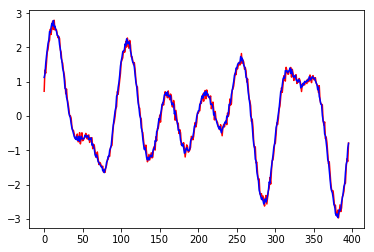

In [46]:
predict_data = np.zeros([396,4])
for i in range(396):
    predict_data[i] = pre_d[i:i + 4]

ans = ex_2_model.prediction(predict_data)
plt.plot(ans.reshape(396), "-r", pre_d[4:], "-b")
plt.show()

# example 3
## weight test

random 0, 1 answer on $[-2, 2]$

set weight = 0 on $[-2, 2]$

compare weighted and non-weighted model

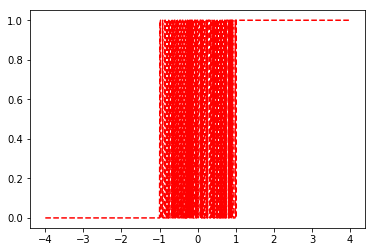

In [52]:
data = ((np.arange(800) - 400)/100).reshape(800,1)
answer = np.zeros((800,1)) + (data > 1.) + ((abs(data) < 1.) * np.random.randint(0,2, (800,1)))
weight = np.zeros((800)) + (abs(data.reshape(800)) > 1.)


plt.plot(data.reshape(800), answer.reshape(800), "--r")
plt.show()

In [53]:
ex_3_model = DogikoNN()
ex_3_w_model = DogikoNN()

ex_3_model.set_training_data(data, answer)
ex_3_model.set_validating_data(data, answer)
ex_3_model.define_normalization("normal")
ex_3_model.insert_layer(
    "A",
    Layer(
        layers_from=["input source"],
        nodes_n=1,
        active_function=Sigmoid()
    )
)

ex_3_model.build()

ex_3_w_model.set_training_data(data, answer, weight)
ex_3_w_model.set_validating_data(data, answer, weight)
ex_3_w_model.define_normalization("normal")
ex_3_w_model.insert_layer(
    "A",
    Layer(
        layers_from=["input source"],
        nodes_n=1,
        active_function=Sigmoid()
    )
)
ex_3_w_model.build()

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:109: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:130: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


10 0.387060183143
20 0.346530245021
30 0.33131295404
40 0.322855925634
50 0.317359345568
60 0.313462553738
70 0.310541371287
80 0.308264347076
90 0.306437351184
100 0.304938356012


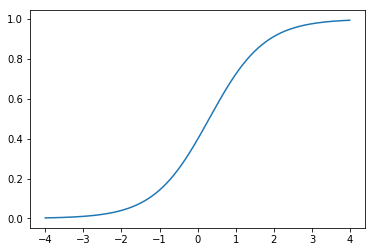

In [54]:
for t in range(100):
    ex_3_model.single_epoch(800, eta = 2)
    if (t+1) % 10 == 0:
        print(t + 1, ex_3_model.validating_error())

plt.plot(data, ex_3_model.prediction(data))
plt.show()

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:300: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:276: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:311: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


100 0.0103100638901
200 0.0091378164823
300 0.00832205815443
400 0.00771062367407
500 0.00722938837443
600 0.00683727446406
700 0.00650940427174
800 0.00622969707948
900 0.00598722596691
1000 0.00577426626292


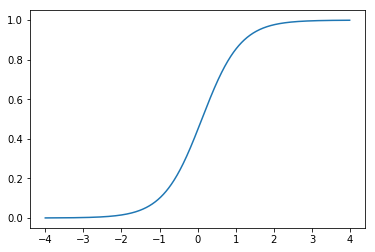

In [57]:
for t in range(1000):
    ex_3_w_model.single_epoch(800, eta = 5)
    if (t+1) % 100 == 0:
        print(t + 1, ex_3_w_model.validating_error())

plt.plot(data, ex_3_w_model.prediction(data))
plt.show()

# example 4



In [15]:
ex_4_model =DogikoNN()

feature = np.random.rand(1000, 1)*4 - 2
result = np.zeros((1000,1))
result += (abs(feature) < 1)

ex_4_model.set_training_data(feature[:500], result[:500])
ex_4_model.set_validating_data(feature[500:], result[500:])

# ex_4_model.define_normalization("normal")
ex_4_model.insert_layer(
    "A",
    Layer(
        layers_from=["input source"],
        nodes_n=2,
        active_function=Hypertan()
    )
)


ex_4_model.insert_layer(
    "B",
    Layer(
        layers_from=["A"],
        nodes_n=1,
        active_function=Sigmoid()
    )
)

ex_4_model.build()

In [64]:
for i in range(1):
    ex_4_model.single_epoch(500, eta=1.)
ex_4_model.validating_error()

0.24439523389641754

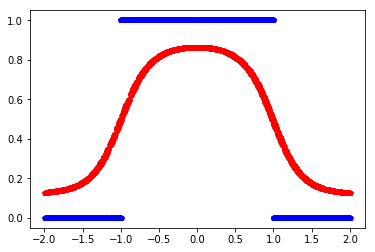

In [65]:
plt.plot(feature.reshape(1000), result.reshape(1000),"bp", feature.reshape(1000), ex_4_model.prediction(feature), "rp")
plt.show()

In [66]:
print(ex_4_model.layers["B"].weights["A"].values)
print(ex_4_model.layers["B"].weights["A"].diff)

[[ 1.98952816  1.99881824]]
[[ 0.01047184  0.00118176]]


In [67]:
print(ex_4_model.layers["B"].bias.values)
print(ex_4_model.layers["B"].bias.diff)

[-2.01048066]
[ 0.01048066]


In [68]:
print(ex_4_model.layers["A"].weights["input source"].values)
print(ex_4_model.layers["A"].weights["input source"].diff)

[[ 2.00000317]
 [-1.99814052]]
[[ -3.16697368e-06]
 [ -1.85947932e-03]]


In [69]:
print(ex_4_model.layers["A"].bias.values)
print(ex_4_model.layers["A"].bias.diff)

[ 1.99996475  1.97930519]
[  3.52463836e-05   2.06948109e-02]


In [83]:
ex_4_model.layers["B"].weights["A"].values = np.array([[2., 2.]])
ex_4_model.layers["B"].bias.values = np.array([-2.])
ex_4_model.layers["A"].weights["input source"].values = np.array([[2.], [-2.]])
ex_4_model.layers["A"].bias.values = np.array([2., 2.])

# Debug

In [70]:
ex_4_model =DogikoNN()

feature = np.array([[-2.], [0.], [2.]])
result = np.array([[0.], [1.], [0.]])

ex_4_model.set_training_data(feature, result)
ex_4_model.set_validating_data(feature, result)

# ex_4_model.define_normalization("normal")
ex_4_model.insert_layer(
    "A",
    Layer(
        layers_from=["input source"],
        nodes_n=2,
        active_function=Hypertan()
    )
)


ex_4_model.insert_layer(
    "B",
    Layer(
        layers_from=["A"],
        nodes_n=1,
        active_function=Sigmoid()
    )
)

ex_4_model.build()

In [85]:
for i in range(1):
    ex_4_model.single_epoch(3, eta=1.)
ex_4_model.validating_error()

0.07520313292705004

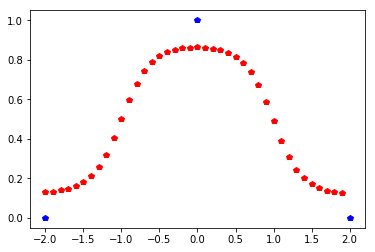

In [86]:

plt.plot(feature.reshape(3), result.reshape(3),"bp", np.arange(40)/10 -2, ex_4_model.prediction((np.arange(40)/10 -2).reshape(40,1)), "rp")
plt.show()

In [28]:
if 1!=2:
    raise ValueError("aaa")

ZeroDivisionError: aaa